# Mise en place

In [10]:
import numpy as np
import scipy.optimize as opt

In [2]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
from dataclasses import dataclass
from typing import Optional

In [61]:
import dash
from dash import dcc
from dash import html
from jupyter_dash import JupyterDash

# Calcul

## Objets à manipuler

In [4]:
@dataclass
class Donnees:
    R: float = 10.
    a: float = 1.5
    b: float = 2.
    d: float = 1.
    c1: float = 1.1
    c2: float = 1.2
    
    def __post_init__(self):
        if (
            self.R < 0 
            or self.a < 0 
            or self.b < 0 
            or self.c1 < 0 
            or self.c2 < 0
        ):
            raise ValueError("Les constantes doivent être positives.")
        if abs(self.d) >= self.b:
            raise ValueError("On doit avoir |d| < b.")

In [5]:
Donnees()

Donnees(R=10.0, a=1.5, b=2.0, d=1.0, c1=1.1, c2=1.2)

In [6]:
@dataclass
class Prix:
    p1: float = 1.
    p2: float = 1.
    
    def __post_init__(self):
        if self.p1 < 0 or self.p2 < 0:
            raise ValueError("Les prix doivent être positifs.")

In [7]:
Prix()

Prix(p1=1.0, p2=1.0)

In [8]:
@dataclass
class Quantites:
    q0: float = 1.
    q1: float = 1.
    q2: float = 1.
    
    def __post_init__(self):
        if self.q0 < 0 or self.q1 < 0 or self.q2 < 0:
            raise ValueError("Les quantités doivent être positives.")

In [9]:
Quantites()

Quantites(q0=1.0, q1=1.0, q2=1.0)

## Calcul de la consommation

In [12]:
def calcule_conso(
    donnees: Optional[Donnees] = None, 
    prix: Optional[Prix]=None
) -> Quantites:
    if donnees is None:
        donnees = Donnees()
    if prix is  None:
        prix = Prix()
        
    def a_minimiser(qs: np.ndarray) -> float:
        q0, q1, q2 = qs
        return (
            donnees.b * (q1 ** 2 + q2 ** 2) / 2
            + donnees.d * q1 * q2
            - q0
            - donnees.a * (q1 + q2)
        )
    
    def a_respecter(qs: np.ndarray) -> float:
        q0, q1, q2 = qs
        return (donnees.R - q0 - prix.p1 * q1 - prix.p2 * q2)
    
    resultat = opt.minimize(
        fun=a_minimiser,
        x0=np.array([0, 0, 0]),
        bounds=[(0, None), (0, None), (0, None)],
        constraints={"type": "ineq", "fun": a_respecter}
    )
    
    if resultat.success:
        return Quantites(*resultat.x)
    else:
        raise ValueError("Impossible de calculer la consommation.")

In [13]:
calcule_conso()

Quantites(q0=9.666666722542459, q1=0.16666663872864176, q2=0.16666663872864199)

## Concurrence en prix

In [16]:
def calcule_reaction1(
    p2: float, 
    donnees: Optional[Donnees] = None
) -> float:
    if donnees is None:
        donnees = Donnees()
    if p2 < 0:
        raise ValueError("Les prix sont positifs.")
    
    def a_minimiser(p1: float) -> float:
        conso = calcule_conso(prix=Prix(p1, p2), donnees=donnees)
        return (donnees.c1 - p1 ) * conso.q1
    
    
    resultat = opt.minimize_scalar(
        fun=a_minimiser,
        bounds=(donnees.c1, None),
    )
    if resultat.success:
        return resultat.x
    else:
        raise ValueError("Impossible de déterminer la réaction.")
        

In [17]:
calcule_reaction1(p2=2.)

1.949109490662484

In [18]:
def calcule_reaction2(
    p1: float, 
    donnees: Optional[Donnees] = None
) -> float:
    if donnees is None:
        donnees = Donnees()
    if p1 < 0:
        raise ValueError("Les prix sont positifs.")
    
    def a_minimiser(p2: float) -> float:
        conso = calcule_conso(prix=Prix(p1, p2), donnees=donnees)
        return (donnees.c2 - p2 ) * conso.q2
    
    
    resultat = opt.minimize_scalar(
        fun=a_minimiser,
        bounds=(donnees.c2, None),
    )
    if resultat.success:
        return resultat.x
    else:
        raise ValueError("Impossible de déterminer la réaction.")

In [19]:
calcule_reaction2(p1=2.)

1.8583336454332697

In [23]:
def essai_nash(donnees: Optional[Donnees] = None) -> Prix:
    if donnees is None:
        donnees = Donnees()
    def a_fixer(ps: np.ndarray) -> np.ndarray:
        p1, p2 = ps
        r1 = calcule_reaction1(p2=p2, donnees=donnees)
        r2 = calcule_reaction2(p1=p1, donnees=donnees)
        return np.array([r1, r2])
    
    resultat = opt.fixed_point(
        func=a_fixer,
        x0=np.array([donnees.c1, donnees.c2]),
    )
    if resultat.success:
        return resultat.x
    else:
        raise ValueError("Impossible de déterminer un équilibre de Nash.")

In [24]:
essai_nash()

ValueError: Les prix sont positifs.

In [29]:
def calcule_nash(donnees: Optional[Donnees] = None) -> Prix:
    if donnees is None:
        donnees = Donnees()
        
    def a_minimiser(ps: np.ndarray) -> float:
        p1, p2 = ps
        r1 = calcule_reaction1(p2=p2, donnees=donnees)
        r2 = calcule_reaction2(p1=p1, donnees=donnees)
        return (r1 - p1) ** 2 + (r2 - p2)**2
        
    resultat = opt.minimize(
        fun=a_minimiser,
        x0=np.array([donnees.c1, donnees.c2]),
        bounds=[(0, None), (0, None)],
    )
    
    if resultat.success:
        return resultat.x
    else:
        raise ValueError("Impossible de déterminer un équilibre de Nash.")

In [30]:
calcule_nash()

array([1.10000019, 1.200001  ])

## Concurrence en quantité

En exercice

on a des fonctions $\tilde{p_1}, \tilde{p_2}$ réciproque de 
$\tilde{q_0}, \tilde{q_1}, \tilde{q_2}$.

On cherche de nouveau un équilibre de Nash mais maintenant les variables de décisions sont les quantités à produire.

# Visualisation

## Programme du consommateur

In [36]:
don = Donnees()
don

Donnees(R=10.0, a=1.5, b=2.0, d=1.0, c1=1.1, c2=1.2)

In [33]:
prix = Prix()
prix

Prix(p1=1.0, p2=1.0)

In [57]:
def genere_niveaux(donnees: Donnees, prix: Prix, nb_points=30):
    q0s = np.linspace(0, donnees.R, nb_points)
    q1s = np.linspace(0, donnees.R / prix.p1, nb_points)
    q2s = np.linspace(0, donnees.R / prix.p2, nb_points)
    Q1, Q2, Q0 = np.meshgrid(q1s, q2s, q0s)
    U = (
        Q0 
        + donnees.a * (Q1 + Q2) 
        - donnees.b * (Q1 ** 2 + Q2 ** 2) / 2
        - donnees.d * Q1 * Q2
    )
    return go.Isosurface(
        x=Q1.flatten(),
        y=Q2.flatten(),
        z=Q0.flatten(),
        value=U.flatten(),
        isomin=0,
        isomax=donnees.R,
        surface_count=3,
        caps=dict(
            x_show=False,
            y_show=False,
            z_show=False,
        )
    )

In [56]:
def genere_contraintes(donnees: Donnees, prix: Prix):
    
    return go.Mesh3d(
        x=[0, 0, donnees.R / prix.p1, 0],
        y=[0, 0, 0, donnees.R / prix.p2],
        z=[0, donnees.R, 0, 0],
        i=[0, 0, 0, 1],
        j=[1, 1, 2, 2],
        k=[2, 3, 3, 3],
        opacity=0.4,
        intensity=[0, 1, 1, 1],
        showscale=False,
    )
        

In [58]:
def visualisation_utilite(donnees: Donnees, prix: Prix):
    niveaux = genere_niveaux(donnees, prix)
    contrainte = genere_contraintes(donnees, prix)
    fig = go.Figure(data=[niveaux, contrainte])
    fig.update_layout(
        width=800,
        height=800,
        scene=dict(
            xaxis_title="Q1",
            yaxis_title="Q2",
            zaxis_title="Q0",
            xaxis_ticktext=["0", "R/p1"], 
            xaxis_tickvals=[0, donnees.R / prix.p1],
            yaxis_ticktext=["0", "R/p2"], 
            yaxis_tickvals=[0, donnees.R / prix.p2],
            zaxis_ticktext=["0", "R"], 
            zaxis_tickvals=[0, donnees.R],
        )
    )
    return fig
    

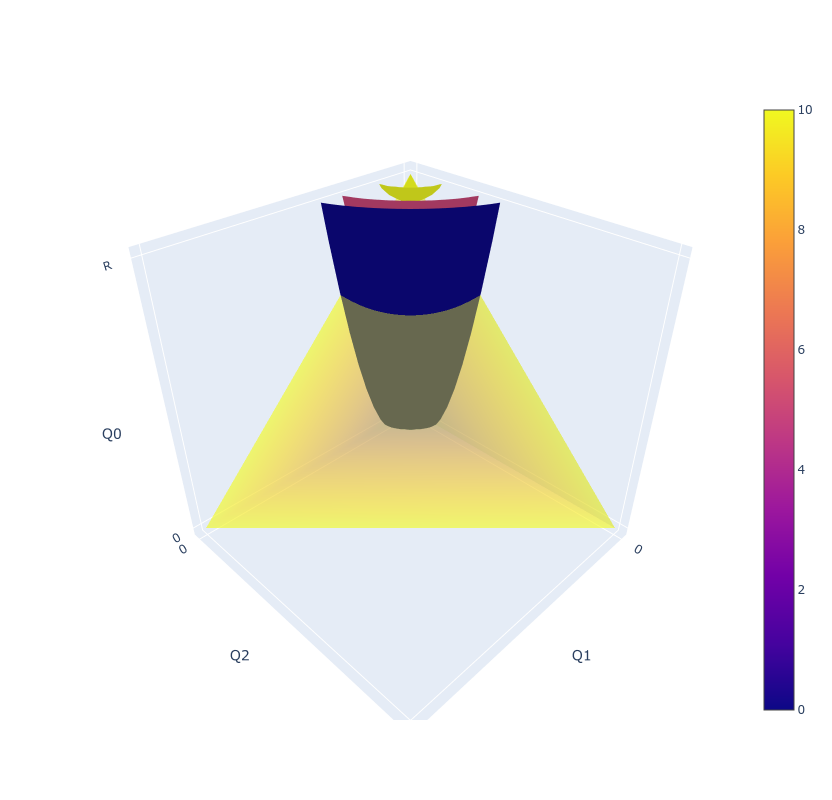

In [59]:
fig = visualisation_utilite(donnees=don, prix=prix)
fig.show()

## Exercice

Visualisation des autres problèmes de maximisation.

# Dashboard

In [78]:
donnees = Donnees()
prix = Prix()
fig = visualisation_utilite(donnees, prix)

app = JupyterDash(__name__) # à modifier par dash.App si à l'extérieur d'un notebook

app.layout = html.Div([
    html.H1("Programme du consommateur."),
    html.Div("",id="deboguage"),
    html.Div(str(donnees), id="donnees"),
    html.Div(str(prix), id="prix"),
    html.Label(["a", dcc.Slider("slider_a", min=0.5, max=10., step=0.5, value=4.)]),
    html.Label(["b", dcc.Slider("slider_b", min=0.5, max=10., step=0.5, value=4.)]),
    html.Label(["d", dcc.Slider("slider_d", min=0.5, max=10., step=0.5, value=2.)]),
    html.Label(["R", dcc.Slider("slider_R", min=0.5, max=10., step=0.5, value=10.)]),
    html.Label(["p1", dcc.Slider("slider_p1", min=0.5, max=10., step=0.5, value=2.)]),
    html.Label(["p2", dcc.Slider("slider_p2", min=0.5, max=10., step=0.5, value=2.)]),
    dcc.Graph(id="figure", figure=fig),
])

@app.callback(
    [
        dash.dependencies.Output("donnees", "children"),
        dash.dependencies.Output("prix", "children"),
    ],
    [
        dash.dependencies.Input("slider_a", "value"),
        dash.dependencies.Input("slider_b", "value"),
        dash.dependencies.Input("slider_d", "value"),
        dash.dependencies.Input("slider_R", "value"),
        dash.dependencies.Input("slider_p1", "value"),
        dash.dependencies.Input("slider_p2", "value"),
    ]
)
def maj_donnees(a, b, d, R, p1, p2):
    donnees.a = a
    donnees.b = b
    donnees.d = d
    donnees.R = R
    prix.p1 = p1
    prix.p2 = p2
    return str(donnees), str(prix)

    
app.run_server(mode="inline")
    